<div style="text-align: center;">
    <a href="https://www.dataia.eu/">
        <img border="0" src="https://github.com/ramp-kits/template-kit/raw/main/img/DATAIA-h.png" width="90%"></a>
</div>

# Predicting Energy Consumption in a Building

<i> AIRAUD Audrey - CHAMPAGNE Mathis - CORREC Romeo - ESTIGNARD Foucauld - TOUMI Nathan </i>

<i><b> Master's students at Institut Polytechnique de Paris </b></i>

## Introduction

The dataset comes from a wireless sensor network installed in a house, collecting temperature and humidity data from different rooms. It also includes weather data from a nearby airport station and recorded energy usage of lighting fixtures and appliances. 

The goal is to develop predictive models that accurately estimate household energy consumption based on the available data. By identifying key factors that influence energy use, participants will refine their models to enhance prediction accuracy and uncover meaningful patterns,

Understanding and predicting energy use is key to reducing waste, cutting costs, and supporting sustainability. Better energy management helps improve home automation, use resources more efficiently, and reduce environmental impact. Insights from this challenge can lead to new ideas and solutions, helping homeowners, energy providers, and policymakers create a greener and more efficient future.

To create this challenge, we found inspiration in the article <em>Data driven prediction models of energy use of appliances in a low-energy house</em> published in 2017, written by Luis M. Candanedo et. al. 

## Description of the house

The house, located in Stambruges, Belgium, was built in December 2015 and has an annual heating and cooling load below 15 kWh/m². A wood stove provides most of the heating, and air leakage is 0.6 ACH at 50 Pa. It features high insulation (U < 0.1 W/m²K), triple-glazed windows (Ug = 0.5 W/m²K, Uf < 0.9 W/m²K), and heat recovery ventilation (90-95% efficiency). The total area is 280 m², with 220 m² heated, and it houses four occupants.

Energy consumption is monitored using M-BUS meters, logging data every 10 minutes. Appliances account for 70-79% of electricity use, while LED lighting represents 1-4%. A ZigBee wireless sensor network tracks temperature and humidity with DHT-22 sensors (±0.5°C, ±3% RH), transmitting data every 3.3 minutes. Weather data from Chièvres Airport (12 km away) is merged using linear interpolation. The dataset spans 137 days (4.5 months) and is analyzed in R, incorporating additional features like weekday classification and time since midnight.

<img src="house_picture.png" alt="Description de l'image" width="600">


A particular aspect of this challenge is the fact that we now have data collected from January to April, while the model will be evaluated on May data. This introduces a potential drift issue due to seasonal changes, emphasizing the need for methods capable of robustly generalizing across temporal shifts.

## The features


<li> <code><b><span style="color:black">date</span></b></code>: written in the format year-month-day hour:minute:second <BR> 
It covers Janauary 2016 to April 2016. The Test Set covers May 2016 
<BR> <li> <code><b><span style="color:black">Appliances</span></b></code>, energy use in Wh <BR> <li> <code><b><span style="color:black">lights</span></b></code>, energy use of light fixtures in the house in Wh <BR> 
<li> <code><b><span style="color:black">Tk</span></b></code>, with k &in; [1, 9], the Temperature in Celsius mesured by the sensors located respectively in the kitchen, living room, laundry room, office room, bathroom, outside the building, ironing room, teenager room 2, parents room <BR> 
<li> <code><b><span style="color:black">RH_k</span></b></code>, with k &in; [1, 9], the Humidity in in % mesured by the sensors located respectively in the kitchen, living room, laundry room, office room, bathroom, outside the building, ironing room, teenager room 2, parents room <BR> 
<li><code><b><span style="color:black">To</span></b></code>, Temperature outside from Chièvres weather station, in Celsius <BR> 
<li> <code><b><span style="color:black">Pressure</span></b></code> from Chièvres weather station, in mm Hg <BR> 
<li> <code><b><span style="color:black">RH_out</span></b></code>, Humidity outside from Chièvres weather station, in % <BR> 
<li> <code><b><span style="color:black">Windspeed</span></b></code> from Chièvres weather station, in m/s <BR> 
<li> <code><b><span style="color:black">Visibility</span></b></code> from Chièvres weather station, in km <BR> 
<li> <code><b><span style="color:black">Tdewpoint</span></b></code> the dew point from Chièvres weather station, in °C <BR> 
The dew point temperature is the temperature at which air must be cooled, at constant pressure, for the water vapor it contains to condense into liquid droplets. It is a key indicator of humidity: the higher the dew point, the more moisture is in the air. <BR>
<li> <code><b><span style="color:black">rv1</span></b></code>, Random variable 1, nondimensional <BR> 
<li> <code><b><span style="color:black">rv2</span></b></code>, Random variable 2, nondimensional <BR>
These two variables were introduced by randomly shuffling original variables. They have no predicting power for the appliances’energy consumption. For feature selection, it can help to see if the selected variables are consistent with the task at hand.

# Exploratory data analysis

The first step of this challenge is to explore and analyze the dataset to gain initial insights. Below are a few visualizations that help us better understand its structure and key patterns.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
pd.set_option('display.max_columns', None)

# Load the data

import problem
X_df, y = problem.get_train_data()

In [4]:
df = pd.concat([X_df, y], axis=1)
df.index = pd.to_datetime(df.index)

First, let's take a look at the tabular data: 

In [5]:
df.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,50
2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


The first question we ask in this challenge is whether temperature varies significantly from one month to another, from one week to antoher, from one hour to the other. 

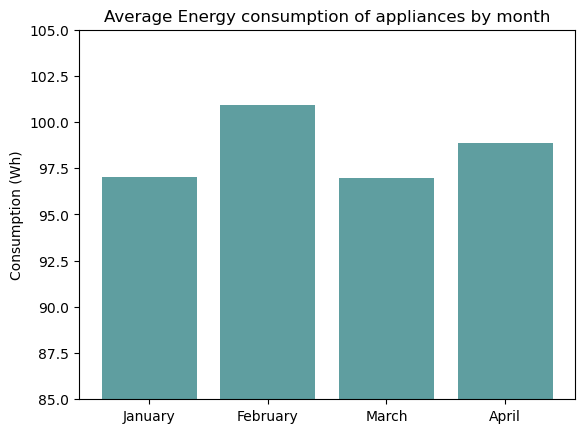

In [6]:
n_months = df.index.month.nunique()
plt.title('Average Energy consumption of appliances by month')
plt.bar(range(n_months), df['Appliances'].groupby(df.index.month).mean(), color='cadetblue')
plt.xticks(range(n_months), [calendar.month_name[i+1] for i in range(n_months)])
plt.ylabel("Consumption (Wh)")
plt.ylim(85, 105)
plt.show()

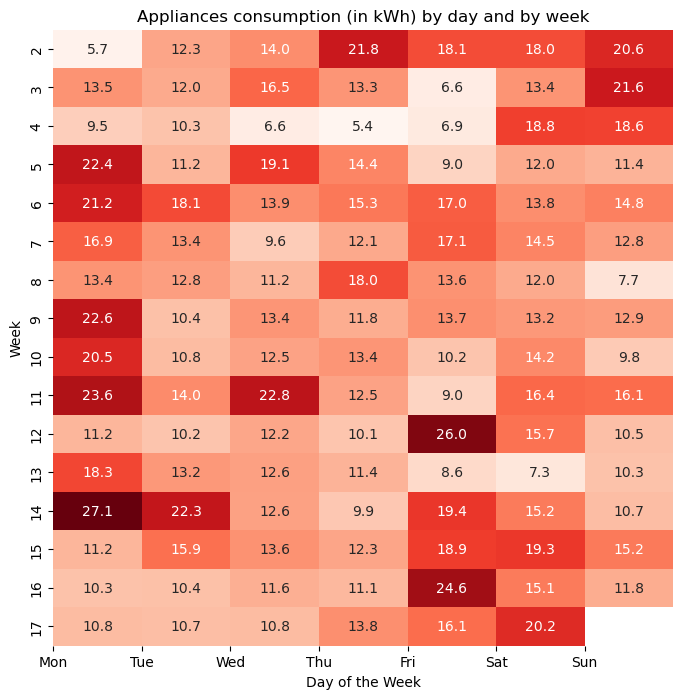

In [11]:
daily_data = df['Appliances'].resample('D').sum()

weekly_data = daily_data.to_frame()
weekly_data['Week'] = weekly_data.index.isocalendar().week
weekly_data['DayOfWeek'] = weekly_data.index.dayofweek

pivot_data = weekly_data.pivot_table(index='Week', columns='DayOfWeek', values='Appliances', aggfunc='sum')

plt.figure(figsize=(8, 8))
sns.heatmap(pivot_data/1000, cmap='Reds', annot=True, fmt=".1f", cbar=False) #, cbar_kws={'label': 'Sum of appliances conso (kWh)'})
plt.title('Appliances consumption (in kWh) by day and by week')
plt.xlabel('Day of the Week')
plt.ylabel('Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

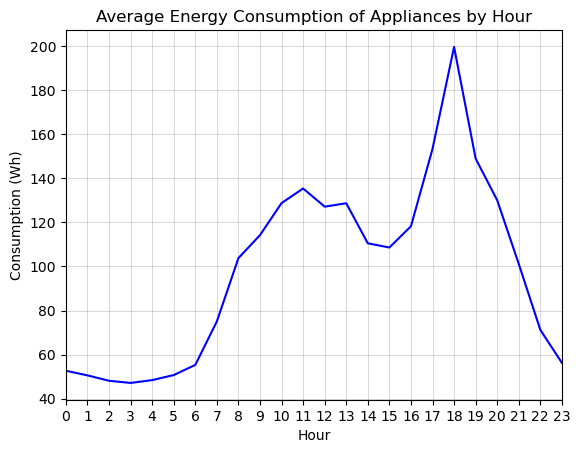

In [14]:
plt.title('Average Energy Consumption of Appliances by Hour')
plt.plot(df['Appliances'].groupby(df.index.hour).mean(), linestyle='-', color='blue')
plt.xlabel('Hour')
plt.ylabel('Consumption (Wh)')
plt.xlim((0, 23))
plt.xticks(range(24))
plt.grid(True, linewidth=0.5, alpha=0.7)
plt.show()

And does the energy consumption depends on the outdoor temperature ? 

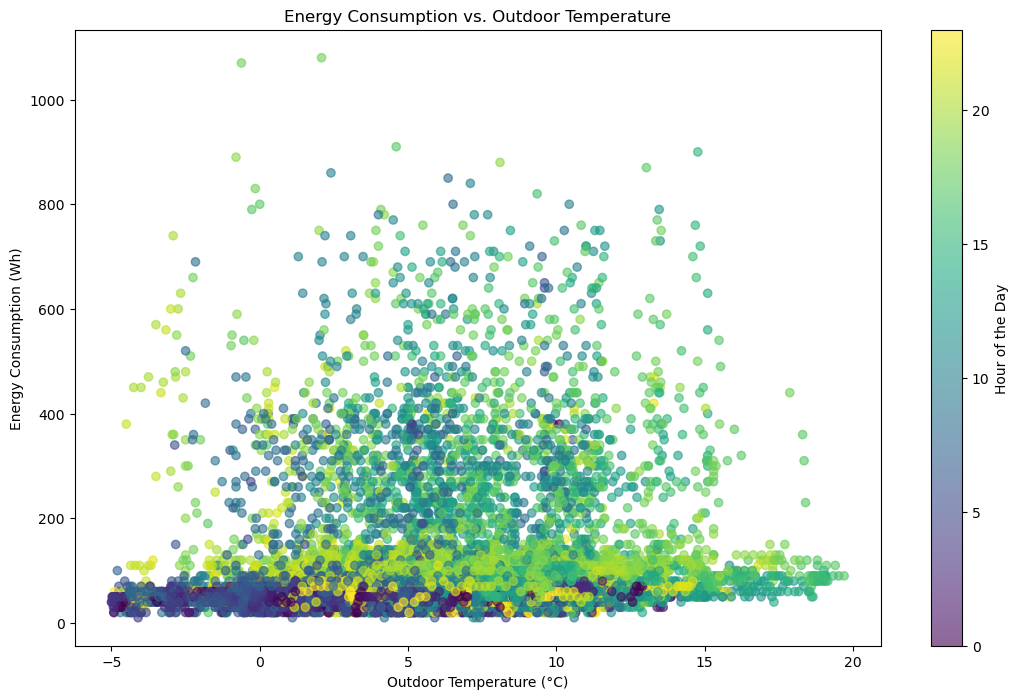

In [15]:
df['Hour'] = df.index.hour 
plt.figure(figsize=(13,8))
scatter = plt.scatter(df['T_out'], df['Appliances'], c=df['Hour'], cmap='viridis', alpha=0.6)
plt.xlabel("Outdoor Temperature (°C)")
plt.ylabel("Energy Consumption (Wh)")
plt.title("Energy Consumption vs. Outdoor Temperature")
cbar = plt.colorbar(scatter)
cbar.set_label("Hour of the Day")
plt.show()

# Challenge evaluation

A particularly important point in a challenge is to describe how it is evaluated. This is the section where you should describe the metric that will be used to evaluate the participants' submissions, as well as your evaluation strategy, in particular if there is some complexity in the way the data should be split to ensure valid results.

# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the RAMP plateform.

This section also show how to use the `ramp-workflow` library to test the submission locally.

## The pipeline workflow

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [ ]:
# %load submissions/starting_kit/estimator.py

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def get_estimator():
    pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )

    return pipe


## Testing using a scikit-learn pipeline

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(get_estimator(), X_df, y, cv=5, scoring='accuracy')
print(scores)

c:\ENPC\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\ENPC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ENPC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproce

[0.10733396 0.16336166 0.10547859 0.13476071 0.1715995 ]


c:\ENPC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).